In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from datetime import datetime
from datetime import timedelta
import pandas_datareader.data as web
import warnings
warnings.filterwarnings('ignore')

manu_sales = web.DataReader('MNFCTRSMNSA', 'fred', '1992', '2022').squeeze()
manu_sales

DATE
1992-01-01    209438
1992-02-01    232679
1992-03-01    249673
1992-04-01    239666
1992-05-01    243231
               ...  
2021-09-01    530156
2021-10-01    529691
2021-11-01    515961
2021-12-01    528638
2022-01-01    495157
Name: MNFCTRSMNSA, Length: 361, dtype: int64

In [2]:
manu_sales.isnull().any()

False

In [3]:
from scipy.stats.stats import moment
from statsmodels.tsa.stattools import adfuller
import scipy.stats as sp
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import gaussian_kde, norm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from matplotlib.offsetbox import AnchoredText
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import math

def show_stats(currency):
    var = np.var(currency)
    mean = np.mean(currency)
    skew = sp.skew(currency)
    kurtosis = sp.kurtosis(currency)
    string = f" Mean: {mean:.4f}\n Var: {var:.4f}\n Skew: {skew:.4f} \n Kurt: {kurtosis:.4f} \n ADF(p-val): {adfuller(currency)[1]:.4f}"
    return string

def plot_data(curr_list, curr_names, title_name):
    title_name = str(title_name)
    num_of_currencies = len(curr_list)
    sns.set_style('dark')
    fig, axs = plt.subplots(num_of_currencies, sharex=True, figsize=(12, 12))
    fig.suptitle(title_name)
    for i, name in enumerate(curr_names):
        axs[i].set_title(name)
    for i, obj in enumerate(curr_list):
        axs[i].plot(obj, c='m')
        axs[i].text(x=0.83, y=0.6, s=show_stats(obj),transform=axs[i].transAxes, c='lime')

def plot_correlation(currency,title_name, lags=None):
    lags = min(10, int(len(currency)/5)) if lags is None else lags
    sns.set_style('darkgrid')
    fig, axs = plt.subplots(2,2, figsize=(12, 12))
    fig.suptitle(title_name)

    axs[0][0].hist(currency, density=True, label="Hist")
    axs[0][0].set_title("Histogram")

    qqplot(currency, line="s", ax=axs[0][1])
    axs[0][1].set_title("Normal Q-Q")

    plot_acf(x=currency, lags=lags, zero=False, ax=axs[1][0])
    axs[1][0].set_title("ACF")


    plot_pacf(x=currency, lags=lags, zero=False, ax=axs[1][1])
    axs[1][1].set_title("PACF")


    fig.tight_layout()
    fig.subplots_adjust(top=.9)
    plt.show()


In [4]:
len(manu_sales)

361

In [5]:
(len(manu_sales)-12)

349

In [6]:
int((len(manu_sales)-12)*.8)

279

In [7]:
manu_sales.index[279]

Timestamp('2015-04-01 00:00:00')

In [8]:
train_end = 279
test_end = 349

train_idx = manu_sales.index[:train_end]
val_idx = manu_sales.index[train_end:test_end]
test_idx = manu_sales.index[test_end:]


train = manu_sales[train_idx]
val = manu_sales[val_idx]
test = manu_sales[test_idx]

print(train_idx)

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01',
               '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01',
               '2015-02-01', '2015-03-01'],
              dtype='datetime64[ns]', name='DATE', length=279, freq=None)


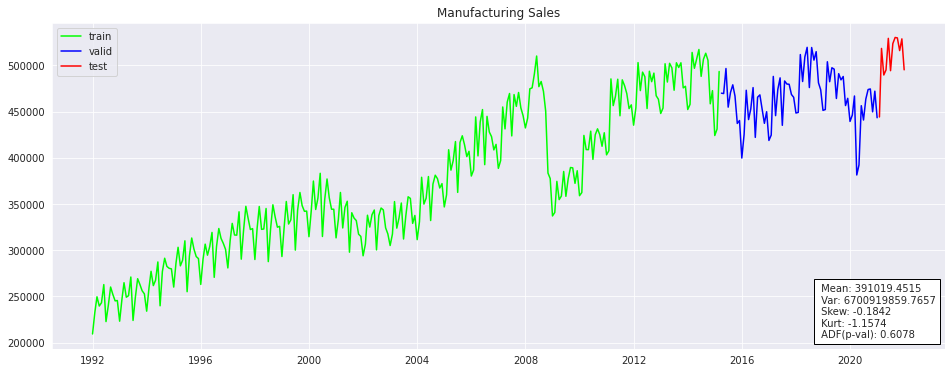

In [9]:
def plot_data(train=None, valid=None, test=None, full=None,title=str, mode = "full"):
    sns.set_style('darkgrid')
    plt.figure(figsize=(16,6))
    plt.title(title)
    if mode == "full":
        plt.plot(full, c='lime')
        a = AnchoredText(s=show_stats(full), loc=4, borderpad=0.5)
    elif mode == "train":
        plt.plot(train, c='lime')
        a = AnchoredText(s=show_stats(train), loc=4, borderpad=0.5)
    elif mode == "mult":
        plt.plot(train, c='lime')
        plt.plot(valid, c='blue')
        plt.plot(test, c='red')
        plt.legend(['train', 'valid', 'test'])
        a = AnchoredText(s=show_stats(full), loc=4, borderpad=0.5)
    plt.gca().add_artist(a)
    plt.show()

plot_data(train=train, valid=val, test=test, full=manu_sales,title="Manufacturing Sales", mode="mult")

In [11]:
log_train = np.log(train)
diff_train = log_train.diff(12).dropna()

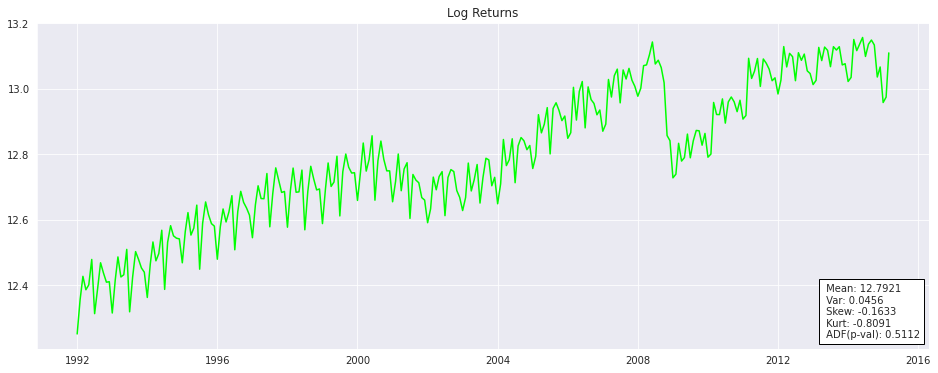

In [12]:
plot_data(train=log_train, title="Log Returns", mode="train")

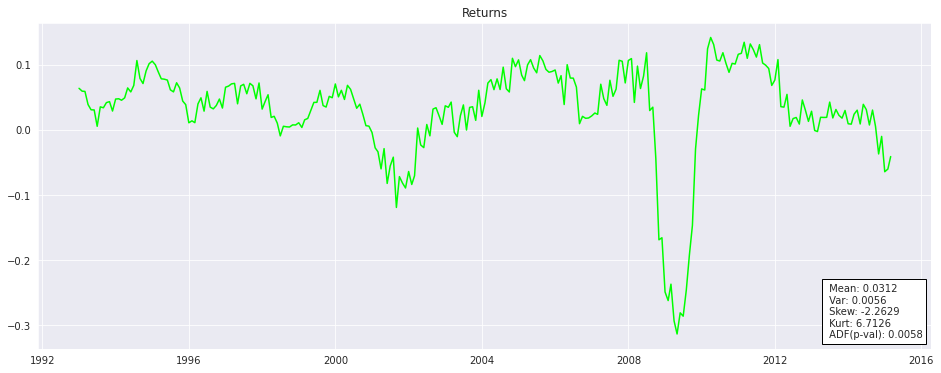

In [13]:
plot_data(train=diff_train, title="Returns", mode="train")

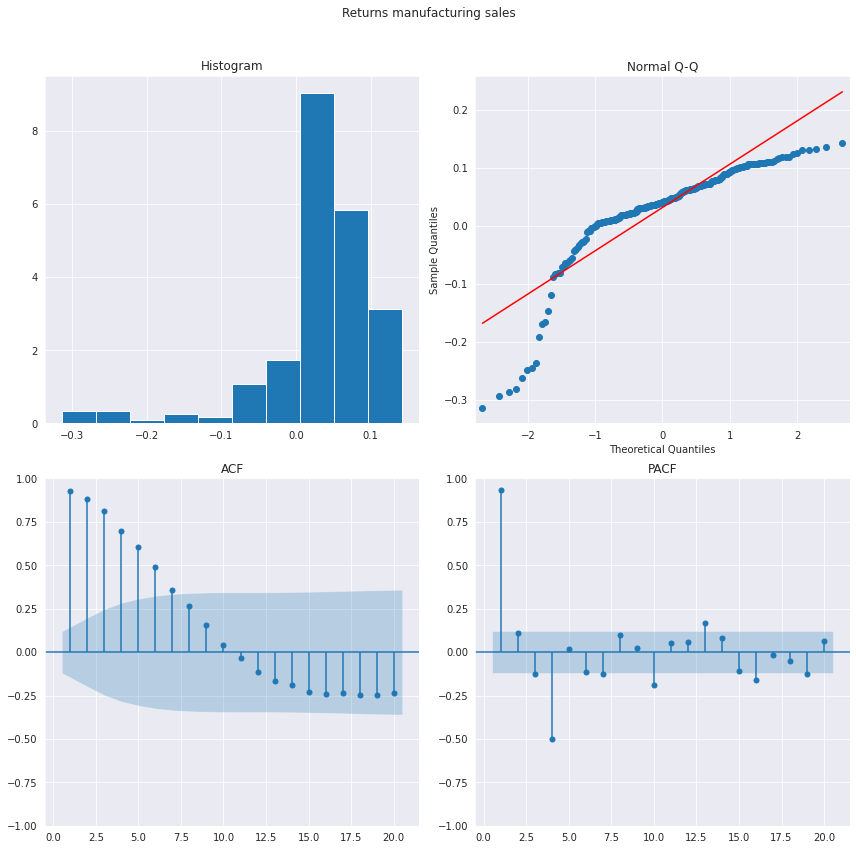

In [14]:
plot_correlation(diff_train,title_name="Returns manufacturing sales",lags=20)

In [15]:
def RMSPE(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true))))
    return loss

In [16]:
warnings.filterwarnings('ignore')
model = SARIMAX(endog=train,
                order=(1, 0, 1),
                seasonal_order=(1, 0, 1, 12),).fit(disp=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        MNFCTRSMNSA   No. Observations:                  279
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -2983.403
Date:                            Wed, 18 May 2022   AIC                           5976.806
Time:                                    22:58:41   BIC                           5994.962
Sample:                                01-01-1992   HQIC                          5984.090
                                     - 03-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9896      0.006    160.177      0.000       0.977       1.002
ma.L1         -0.2407      0.034     -7.003      0.000      -0.308      -0.173
ar.S.L12       0.9986      0.001    912.669      0.000       0.997       1.001
ma.S.L12      -0.7896      0.030    -26.234      0.000      -0.849      -0.731
sigma2        9.5e+07   1.15e-10   8.26e+17      0.000     9.5e+07     9.5e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):               329.96
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               7.44   Skew:                            -0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.19e+33. Standard errors may be unstable.
"""

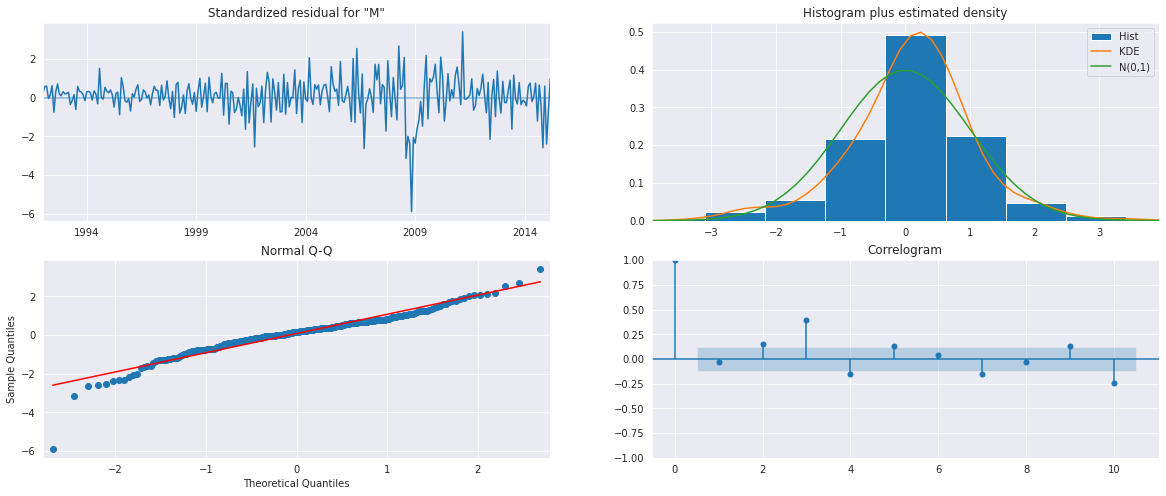

In [17]:
model.plot_diagnostics(figsize=(20,8))
plt.show()

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

rolling_forecasts = []
residuals = []

for i in range(len(val)):
    idx = val_idx[i]
    train = manu_sales[:idx]
    sarimax_model = SARIMAX(endog=train,
                            order=(1, 0, 4),
                            seasonal_order=(1, 0, 1, 12),
                            simple_differencing=True,
                            initialization='approximate_diffuse')
    model_fit = sarimax_model.fit(disp=0)
    pred = model_fit.forecast()
    rolling_forecasts.append(pred)
    y = val[i]
    yhat = pred[0]
    res = y - yhat
    residuals.append(res)
    print(f"Observed: {y} Predicted: {yhat:.4f} Residuals: {res:.4f}")

rolling_predictions = pd.Series(rolling_forecasts, index=val.index)


Observed: 469899 Predicted: 483843.9749 Residuals: -13944.9749
Observed: 469475 Predicted: 481002.5572 Residuals: -11527.5572
Observed: 496586 Predicted: 465917.6909 Residuals: 30668.3091
Observed: 454788 Predicted: 466173.8564 Residuals: -11385.8564
Observed: 470575 Predicted: 480117.4782 Residuals: -9542.4782
Observed: 478931 Predicted: 466758.8826 Residuals: 12172.1174
Observed: 466724 Predicted: 437641.6590 Residuals: 29082.3410
Observed: 437157 Predicted: 445687.5235 Residuals: -8530.5235
Observed: 440316 Predicted: 408890.6690 Residuals: 31425.3310
Observed: 399750 Predicted: 402547.7481 Residuals: -2797.7481
Observed: 425230 Predicted: 456164.0283 Residuals: -30934.0283
Observed: 473035 Predicted: 459435.5426 Residuals: 13599.4574
Observed: 441341 Predicted: 449475.0015 Residuals: -8134.0015
Observed: 452785 Predicted: 463631.2782 Residuals: -10846.2782
Observed: 475935 Predicted: 440881.0243 Residuals: 35053.9757
Observed: 422080 Predicted: 440744.9284 Residuals: -18664.9284
Ob

In [19]:
rmse_model_1 = np.sqrt(mean_squared_error(val, rolling_predictions))
mae_model_1 = mean_absolute_percentage_error(val, rolling_predictions)
print(f"Test RMSE: {rmse_model_1}")
print(f"Model-1 MAE: {mae_model_1}")

Test RMSE: 20790.215367596214
Model-1 MAE: 0.037530143939902276


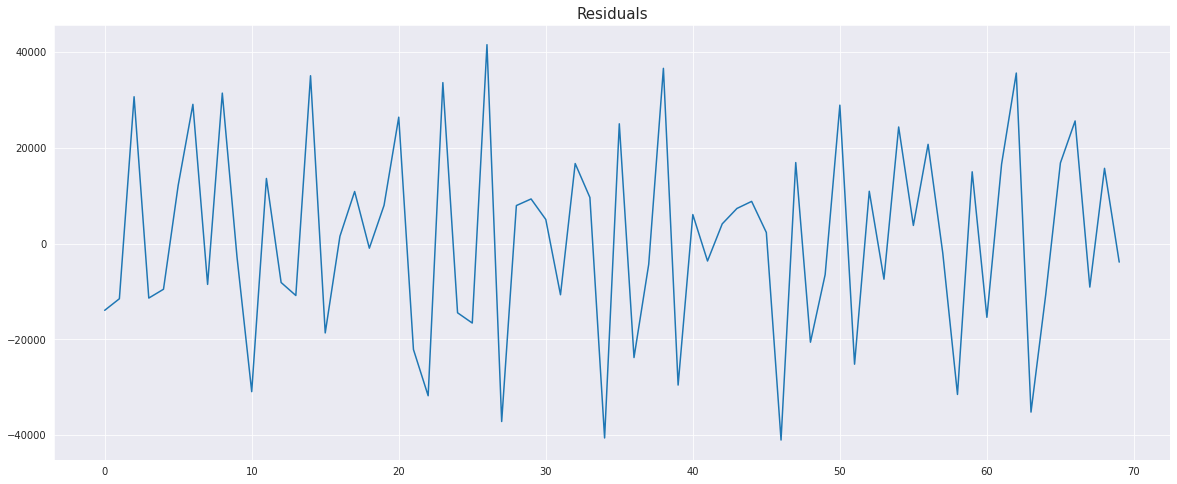

In [20]:
plt.figure(figsize=(20,8))
plt.title("Residuals",fontsize=15)
plt.plot(residuals)
plt.show()

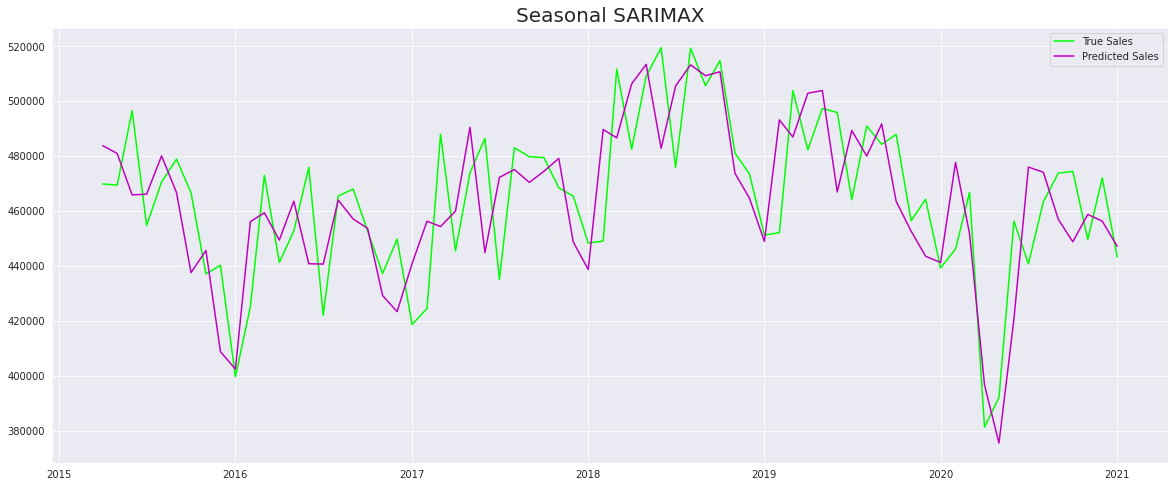

In [21]:
#summary of the model
plt.figure(figsize=(20,8))
plt.title("Seasonal SARIMAX", fontsize=20)
plt.plot(val, c='lime', label='True Sales')
plt.plot(rolling_predictions, c='m', label='Predicted Sales')
plt.legend()
plt.show()

In [22]:
from itertools import product
from numpy.linalg import LinAlgError

l3 = list(range(3))
l4 = list(range(4))
params = [t for t in product(l4, l4, l3, l3) if t[0] > 0 and t[1] >  0]
len(params)

81

In [23]:
# from tqdm import tqdm
# results = {}
#
# for p1, q1, p2, q2 in tqdm(params):
#     rolling_forecasts = []
#     aic, bic = [], []
#     if p1 == 0 and q1 == 0:
#        continue
#
#     for i in range(len(val)):
#         idx = val_idx[i]
#         train = manu_sales[:idx]
#
#         model = SARIMAX(endog=train,
#                         order=(p1, 0, q1),
#                         seasonal_order=(p2, 0, q2, 12),
#                         initialization='approximate_diffuse',
#                         simple_differencing=True,
#                         enforce_stationarity=True)
#
#         model_fit = model.fit(disp=0)
#         pred = model_fit.forecast(horizon=1, reindex=False)
#         rolling_forecasts.append(pred)
#         aic.append(model_fit.aic)
#         bic.append(model_fit.bic)
#
#     rolling_predictions = pd.Series(rolling_forecasts, index=val.index)
#     results[(p1, q1, p2, q2)] = [np.sqrt(mean_squared_error(val, rolling_predictions)),
#                                  mean_absolute_percentage_error(val, rolling_predictions),
#                                  np.mean(aic),
#                                  np.std(aic),
#                                  np.mean(bic),
#                                  np.std(bic),
#                                  ]
#
# sarimax_results = pd.DataFrame(results).T
# sarimax_results.columns = ['RMSE', 'MAPE', 'AIC_mean', 'AIC_std', 'BIC_mean', 'BIC_std']
# sarimax_results.index.names = ['p1', 'q1', 'p2', 'q2']
# sarimax_results.to_csv('sarimax_results.csv')
# print("Results are saved in csv file...")
# sarimax_results.info()

In [24]:
results = pd.read_csv('sarimax_results.csv')
results.sort_values(by="AIC_mean", ascending=True)

,p1,q1,p2,q2,RMSE,MAPE,AIC_mean,AIC_std,BIC_mean,BIC_std
79,3,3,2,1,24785.115857,0.042965,50815.366281,453.720790,50852.855407,454.364449
80,3,3,2,2,24762.500669,0.042937,50817.363504,453.722552,50858.601543,454.430577
78,3,3,2,0,24463.892983,0.041955,50841.519894,453.293404,50875.260108,453.872733
70,3,2,2,1,24604.598631,0.043159,50847.364915,453.235717,50881.105128,453.815120
77,3,3,1,2,20182.170556,0.034296,50847.577443,454.713232,50885.066570,455.356953
...,...,...,...,...,...,...,...,...,...,...
9,1,2,0,0,13701.149761,0.024272,51086.701905,468.169625,51101.697556,468.427236
63,3,2,0,0,14176.390143,0.025107,51087.202799,467.981496,51109.696275,468.367909
72,3,3,0,0,13518.005857,0.024529,51087.637021,467.121275,51113.879410,467.572113
36,2,2,0,0,14367.074138,0.025150,51091.460671,470.240606,51110.205234,470.561609


In [25]:
rolling_forecasts_2 = []
residuals_2 = []

for i in range(len(val)):
    idx = val_idx[i]
    train = manu_sales[:idx]
    best_sarimax_fit = SARIMAX(endog=train,
                               order=(3, 0, 3),
                               seasonal_order=(2, 0, 1, 12),
                               simple_differencing=True,
                               enforce_stationarity=True,
                               initialization='approximate_diffuse').fit(disp=0)
    pred = best_sarimax_fit.forecast()
    rolling_forecasts_2.append(pred)
    y = val[i]
    yhat = pred[0]
    res = y - yhat
    residuals_2.append(res)
    print(f"Observed: {y} Predicted: {yhat:.4f} Residuals: {res:.4f}")

rolling_predictions_2 = pd.Series(rolling_forecasts_2, index=val.index)

Observed: 469899 Predicted: 478182.5112 Residuals: -8283.5112
Observed: 469475 Predicted: 482055.2618 Residuals: -12580.2618
Observed: 496586 Predicted: 468261.8167 Residuals: 28324.1833
Observed: 454788 Predicted: 467805.2375 Residuals: -13017.2375
Observed: 470575 Predicted: 477740.9627 Residuals: -7165.9627
Observed: 478931 Predicted: 467321.7699 Residuals: 11609.2301
Observed: 466724 Predicted: 423041.5675 Residuals: 43682.4325
Observed: 437157 Predicted: 447906.6042 Residuals: -10749.6042
Observed: 440316 Predicted: 397871.6137 Residuals: 42444.3863
Observed: 399750 Predicted: 406007.9655 Residuals: -6257.9655
Observed: 425230 Predicted: 473759.3043 Residuals: -48529.3043
Observed: 473035 Predicted: 452904.6672 Residuals: 20130.3328
Observed: 441341 Predicted: 444482.8577 Residuals: -3141.8577
Observed: 452785 Predicted: 474598.7428 Residuals: -21813.7428
Observed: 475935 Predicted: 436623.5303 Residuals: 39311.4697
Observed: 422080 Predicted: 437498.3283 Residuals: -15418.3283
Ob

In [26]:
from sklearn.metrics import mean_absolute_percentage_error

rsme_model_2 = np.sqrt(mean_squared_error(val, rolling_predictions_2))
mae_model_2 = mean_absolute_percentage_error(val,rolling_predictions_2)
print(f"Model-2 RMSE: {rsme_model_2}")
print(f"Model-2 MAE: {mae_model_2}")

Model-2 RMSE: 24785.11585696232
Model-2 MAE: 0.04296453468620813


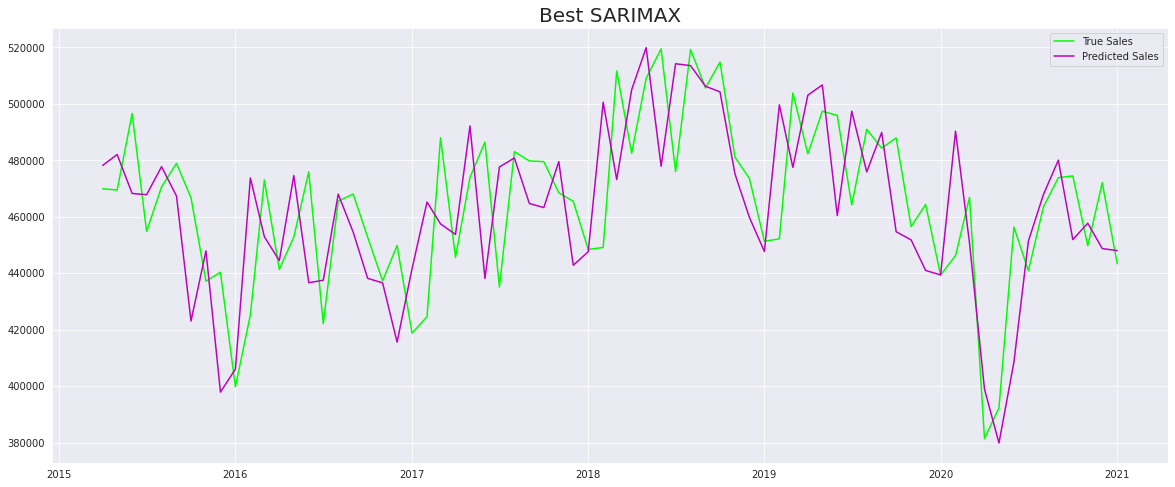

In [27]:
plt.figure(figsize=(20,8))
plt.title("Best SARIMAX", fontsize=20)
plt.plot(val, c='lime', label='True Sales')
plt.plot(rolling_predictions_2, c='m', label='Predicted Sales')
plt.legend()
plt.show()

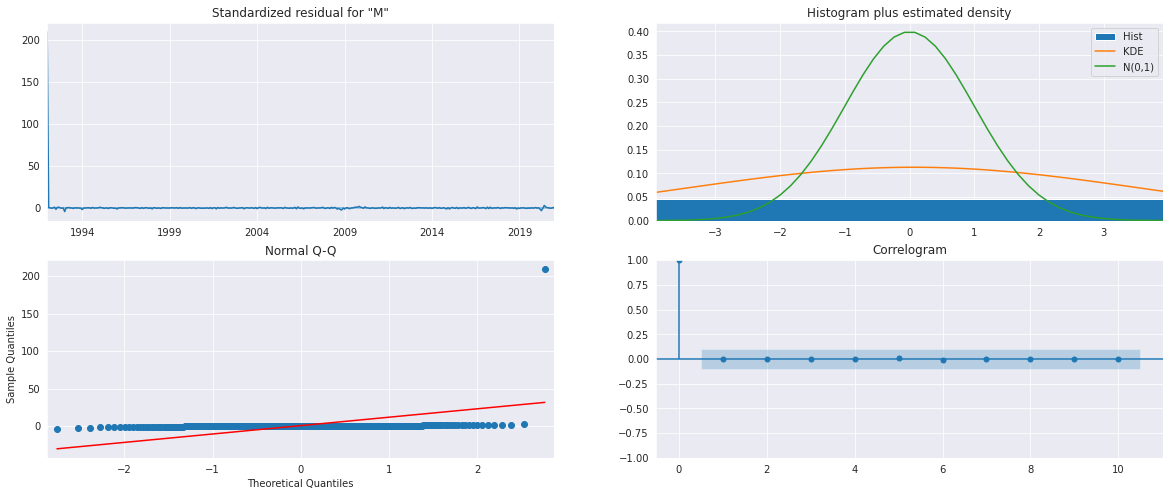

In [28]:
best_sarimax_fit.plot_diagnostics(figsize=(20,8))
plt.show()

# Out of sample prediction

In [29]:
# from arch import arch_model
#
# returns = np.log(manu_sales).diff().dropna()
# y = returns - np.mean(returns)
# std_res_y = y/np.std(y)
#
# train_end = 279
# test_end = 349
#
# train_idx = returns.index[:train_end]
# val_idx = returns.index[train_end:test_end]
# test_idx = returns.index[test_end:]
#
#
# train = returns[train_idx]
# val = returns[val_idx]
# test = returns[test_idx]
#
# plot_data(train=train, valid=val, test=test, full=returns,title="Volatility", mode="mult")

In [30]:
# Standardize
# plot_data(full=std_res_y, title="Log Returns", mode="full")

In [31]:
# rolling_forecasts_3 = []
# residuals_3 = []
#
# for i in range(len(val)):
#     idx = val_idx[i]
#     train = returns[:idx]
#     garch_11_fit = arch_model(train, vol='GARCH', p=1,q=1, mean='zero', dist='normal').fit(disp='off')
#     pred = (garch_11_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5
#     rolling_forecasts_3.append(pred)
#
#     # print(f"Observed: {y} Predicted: {yhat:.4f} Residuals: {res:.4f}")
# rolling_predictions_3 = pd.Series(rolling_forecasts_3, index=val.index)
#
# rsme_model_3 = np.sqrt(mean_squared_error(val, rolling_predictions_3))
# mae_model_3 = mean_absolute_percentage_error(val,rolling_predictions_3)
# print(f"Model-2 RMSE: {rsme_model_3}")
# print(f"Model-2 MAE: {mae_model_3}")

In [32]:
# plt.figure(figsize=(20,8))
# plt.title("Garch ", fontsize=20)
# plt.plot(val, c='lime', label='True Sales')
# plt.plot(rolling_predictions_3, c='m', label='Predicted Sales')
# plt.legend()
# plt.show()

In [33]:
# LSTM model

In [39]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def create_time_series(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1)
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler

window_size = 24
X, y = create_time_series(manu_sales, window_size=window_size)

stand = StandardScaler()
norm = MinMaxScaler()

# Standardized
X_norm = pd.DataFrame(norm.fit_transform(X))
# Normalized
X_stand = pd.DataFrame(stand.fit_transform(X))

X_train_base = X[:train_end].values.reshape(-1,window_size, 1)
y_train_base = y[:train_end]

X_val_base = X[:test_end].values.reshape(-1,window_size, 1)
y_val_base = y[:test_end]

X_train_norm = X_norm[:train_end].values.reshape(-1,window_size, 1)
X_val_norm = X_norm[:test_end].values.reshape(-1,window_size, 1)

X_train_stand = X_stand[:train_end].values.reshape(-1,window_size, 1)
X_val_stand = X_stand[:test_end].values.reshape(-1,window_size, 1)


assert X_train_base.shape == X_train_norm.shape == X_train_stand.shape
assert X_val_base.shape == X_val_norm.shape == X_val_stand.shape
X.head()


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
DATE,,,,,,,,,,,,,,,,,,,,,
1994-01-01,209438,232679,249673,239666,243231,262854,222832,240299,260216,252272,...,264886,249181,250870,271047,224077,248963,269227,263075,256142,252830
1994-02-01,232679,249673,239666,243231,262854,222832,240299,260216,252272,245261,...,249181,250870,271047,224077,248963,269227,263075,256142,252830,234097
1994-03-01,249673,239666,243231,262854,222832,240299,260216,252272,245261,245603,...,250870,271047,224077,248963,269227,263075,256142,252830,234097,259041
1994-04-01,239666,243231,262854,222832,240299,260216,252272,245261,245603,223258,...,271047,224077,248963,269227,263075,256142,252830,234097,259041,277243
1994-05-01,243231,262854,222832,240299,260216,252272,245261,245603,223258,246941,...,224077,248963,269227,263075,256142,252830,234097,259041,277243,261755


In [69]:
import torch

class TimeSeriesDataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        curr_X = self.X[idx]
        curr_y = self.y[idx]
        return (torch.tensor(curr_X,dtype=torch.float), torch.tensor(curr_y, dtype=torch.float))

dataset_train = TimeSeriesDataset(X_train_norm, y_train_base)
dataset_val = TimeSeriesDataset(X_val_norm, y_val_base)

print("Train shape", dataset_train.X.shape, dataset_train.y.shape)
print("Val shape", dataset_val.X.shape, dataset_val.y.shape)

Train shape (279, 24, 1) (279,)
Val shape (337, 24, 1) (337,)


In [70]:
dataset_train[23]

(tensor([[0.1400],
         [0.0380],
         [0.1221],
         [0.1834],
         [0.1312],
         [0.1508],
         [0.2174],
         [0.0563],
         [0.1812],
         [0.2299],
         [0.2000],
         [0.1931],
         [0.1912],
         [0.1222],
         [0.2106],
         [0.2679],
         [0.1999],
         [0.2136],
         [0.2823],
         [0.0714],
         [0.2010],
         [0.2673],
         [0.2270],
         [0.1995]]),
 tensor(290963.))

# LSTM - one two layers

In [76]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)

        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)

        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]


# Traing the model

In [77]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary


In [78]:
model = LSTMModel()
device = torch.device("cpu")

print(summary(model))

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            64
├─ReLU: 1-2                              --
├─LSTM: 1-3                              16,896
├─Dropout: 1-4                           --
├─Linear: 1-5                            65
Total params: 17,025
Trainable params: 17,025
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            64
├─ReLU: 1-2                              --
├─LSTM: 1-3                              16,896
├─Dropout: 1-4                           --
├─Linear: 1-5                            65
Total params: 17,025
Trainable params: 17,025
Non-trainable params: 0


In [93]:


def train(dataloader):
    epoch_loss, epoch_acc = 0, 0
    model.train()
    for idx, (input_x, target_y) in enumerate(dataloader):
        batchsize = 32
        input_x = input_x.to(device)
        target_y = target_y.to(device)
        output = model(input_x)
        loss = criterion(output, target_y)
        loss.backward()
        optimizer.step()


        epoch_acc += ((output>=0.5).float() == target_y).float().sum().item()
        epoch_loss += loss.item()*target_y.size(0)

    lr = scheduler.get_lr()[0]
    total_loss = epoch_loss/len(dataloader.dataset)
    total_acc = epoch_acc/len(dataloader.dataset)

    return total_loss, total_acc, lr

def evaluate(dataloader):
    epoch_loss, epoch_acc = 0, 0
    model.eval()
    with torch.no_grad():
        for idx, (input_x, target_y) in enumerate(dataloader):
            batchsize = 32
            output = model(input_x)
            loss = criterion(output, target_y)

        is_correct = ((output>=0.5).float() == target_y).float().sum().item()
        epoch_loss += loss.item()*target_y.size(0)
        

    total_loss = epoch_loss/len(dataloader.dataset)
    total_acc = epoch_acc/len(dataloader.dataset)

    return total_loss, total_acc





In [94]:

train_dataloader = DataLoader(dataset=dataset_train, batch_size=32, num_workers=2, shuffle=True)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=32, num_workers=2, shuffle=False)

batch = next(iter(train_dataloader))

input, target = batch
print(f"in == {input}\n target == {target}")
print(len(train_dataloader.dataset))

in == tensor([[[0.9697],
         [0.8566],
         [0.8755],
         [0.8393],
         [0.7676],
         [0.5415],
         [0.5217],
         [0.3843],
         [0.3971],
         [0.5106],
         [0.4440],
         [0.4568],
         [0.5467],
         [0.4545],
         [0.5189],
         [0.5600],
         [0.5587],
         [0.4860],
         [0.5307],
         [0.4233],
         [0.4335],
         [0.6421],
         [0.5904],
         [0.5901]],

        [[0.1400],
         [0.0380],
         [0.1221],
         [0.1834],
         [0.1312],
         [0.1508],
         [0.2174],
         [0.0563],
         [0.1812],
         [0.2299],
         [0.2000],
         [0.1931],
         [0.1912],
         [0.1222],
         [0.2106],
         [0.2679],
         [0.1999],
         [0.2136],
         [0.2823],
         [0.0714],
         [0.2010],
         [0.2673],
         [0.2270],
         [0.1995]],

        [[0.0795],
         [0.1221],
         [0.1834],
         [0.1312],
  

In [99]:
num_epochs = 100
lr = 0.01
step_size = 40
batchsize = 64
criterion = torch.nn.MSELoss()
optimizer = Adam(model.parameters(), lr=lr,betas=(0.9, 0.98), eps=1e-9)
scheduler = StepLR(optimizer, step_size=step_size, gamma=0.1)
train_losses=[]
eval_losses=[]

for epoch in range(num_epochs):
    train_loss, train_acc, train_lr = train(dataloader=train_dataloader)
    val_loss, val_acc = evaluate(dataloader=val_dataloader)
    train_losses.append(train_loss)
    eval_losses.append(val_loss)
    scheduler.step()
    print('Epoch[{}/{}] | loss_train:{:.5f} | acc_train:{:.5f} | loss_val:{:.5f} | acc_val:{:.5f} | lr:{:.5f}'.format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc, train_lr))

Epoch[1/100] | loss_train:152715416095.19714 | acc_train:0.00000 | loss_val:12331016410.77745 | acc_val:0.00000 | lr:0.01000
Epoch[2/100] | loss_train:152717167891.26883 | acc_train:0.00000 | loss_val:12330744494.71810 | acc_val:0.00000 | lr:0.01000
Epoch[3/100] | loss_train:152710804615.79929 | acc_train:0.00000 | loss_val:12330471752.16617 | acc_val:0.00000 | lr:0.01000
Epoch[4/100] | loss_train:152702504504.88889 | acc_train:0.00000 | loss_val:12330200662.59941 | acc_val:0.00000 | lr:0.01000
Epoch[5/100] | loss_train:152695117434.95340 | acc_train:0.00000 | loss_val:12329927093.55490 | acc_val:0.00000 | lr:0.01000
Epoch[6/100] | loss_train:152692025263.25449 | acc_train:0.00000 | loss_val:12329654351.00297 | acc_val:0.00000 | lr:0.01000
Epoch[7/100] | loss_train:152693789626.26523 | acc_train:0.00000 | loss_val:12329380781.95846 | acc_val:0.00000 | lr:0.01000
Epoch[8/100] | loss_train:152684169223.34052 | acc_train:0.00000 | loss_val:12329107212.91395 | acc_val:0.00000 | lr:0.01000


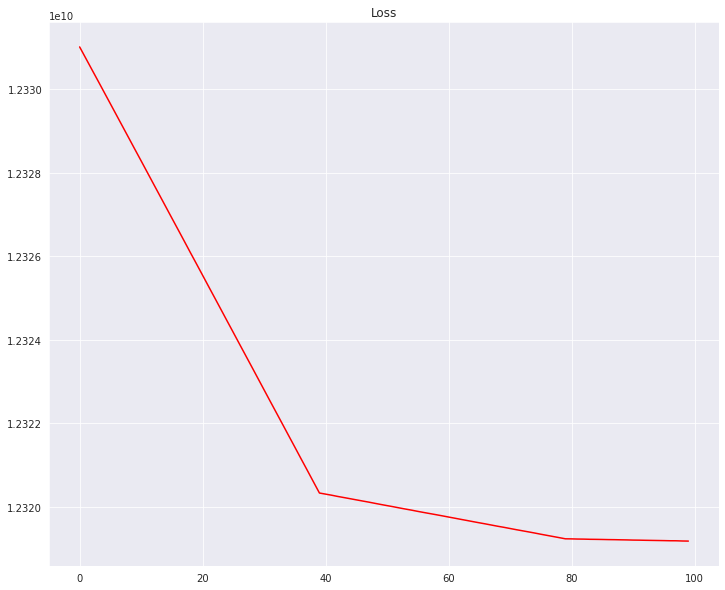

In [101]:
fig = plt.figure(figsize=(12,10))
plt.title("Loss")
#plt.plot(train_losses, c="green", label="Train")
plt.plot(eval_losses, c="red", label="Valid")
